# FOOOFing EEG Data

Analyzing the EEG dataset.

- Note: collection bad trials & components: including zero

Note: data issue with subject 8 mastoids (and I think at least one other subject)

In [1]:
%matplotlib inline

import os
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.signal import periodogram

# MNE & associated code
import mne
from mne.preprocessing import ICA, read_ica
from mne.utils import _time_mask

from autoreject import AutoReject, read_auto_reject
from autoreject.autoreject import _apply_interp

# FOOOF, and custom helper & utility functions
from fooof import FOOOF, FOOOFGroup
from fooof.analysis import get_band_peak, get_band_peak_group

from om.core.utils import clean_file_list

## Settings

In [2]:
# Set subject index to load (as index from subjs_files)
sub_ind = 21

In [3]:
# Preprocessing options
#   If these are false - loads & applies saved solutions
run_ica = False
run_auto_reject = False

In [4]:
# Set paths & settings
res_path = '/Users/tom/Documents/Research/1-Projects/fooof/2-Data/Results/'
dat_path = '/Users/tom/Documents/Data/Voytek_WMData/G2'
extension = '.bdf'

## Data Loading

In [5]:
# Get list of subject files
subj_files = os.listdir(dat_path)
subj_files = clean_file_list(subj_files, extension)

In [6]:
# Get & check which subject is being run
subj_file = subj_files[sub_ind]
subj_label = subj_file.split('.')[0]

print(subj_label)

YA_042007-1_RAW


In [7]:
# Load data, and do things for fixing up the channel labels & types
eeg_dat = mne.io.read_raw_edf(os.path.join(dat_path, subj_file), preload=True)

# Fix channel name labels
eeg_dat.info['ch_names'] = [chl[2:] for chl in eeg_dat.ch_names[:-1]] + [eeg_dat.ch_names[-1]]
for ind, chi in enumerate(eeg_dat.info['chs']):
    eeg_dat.info['chs'][ind]['ch_name'] = eeg_dat.info['ch_names'][ind]

# Set channel types
ch_types = {'LHor' : 'eog', 'RHor' : 'eog', 'IVer' : 'eog', 'SVer' : 'eog',
            'LMas' : 'misc', 'RMas' : 'misc', 'Nose' : 'misc', 'EXG8' : 'misc'}
eog_chs = ['LHor', 'RHor', 'IVer', 'SVer']

# Set channel types
eeg_dat.set_channel_types(ch_types)

Extracting EDF parameters from /Users/tom/Documents/Data/Voytek_WMData/G2/YA_042007-1_RAW.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1406463  =      0.000 ...  2746.998 secs...


<ipython-input-7-5932952b3d51>:2: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  eeg_dat = mne.io.read_raw_edf(os.path.join(dat_path, subj_file), preload=True)


In [8]:
# Keep current reference
#eeg_dat = eeg_dat.set_eeg_reference(ref_channels=[], projection=False, verbose=False)

# Set average reference
eeg_dat = eeg_dat.set_eeg_reference(ref_channels='average', projection=False, verbose=False)

# Set specific reference
#eeg_dat = eeg_dat.set_eeg_reference(['Cz'], projection=False)
#eeg_dat = eeg_dat.set_eeg_reference(['LMas', 'Rmas'], projection=False, verbose=False)

In [9]:
# Get sampling rate
srate = int(eeg_dat.info['sfreq'])

# Check if there are any channels marked bad
eeg_dat.info['bads']

[]

### Montage

In [10]:
# Set channel montage
chs = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)
eeg_dat.set_montage(chs)

<RawEDF  |  YA_042007-1_RAW.bdf, n_channels x n_times : 73 x 1406464 (2747.0 sec), ~783.5 MB, data loaded>

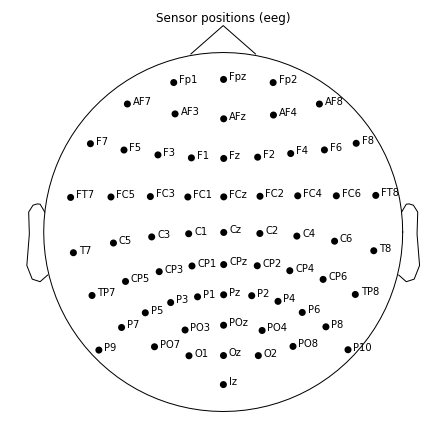

In [11]:
# Check channel positions
eeg_dat.plot_sensors(show_names=True);

### Pre-Processing: ICA

ICA is used to remove eye-related artifact. 

To do so, we do ICA on the data, and then use an MNE function that identifies ICA components to reject based on correlation with EOG channels. 

In [12]:
# High-pass filter for ICA
eeg_dat.filter(l_freq=1., h_freq=None, fir_design='firwin');

Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 1691 samples (3.303 sec) selected


In [13]:
if run_ica:
    
    # ICA settings
    method = 'fastica'
    #method = 'extended-infomax'

    #n_components = 20
    n_components = 0.99
    random_state = 48
    decim = None
    reject = {'eeg': 20e-4}

    # Initialize ICA object
    ica = ICA(n_components=n_components, method=method, random_state=random_state)
    
    # Fit ICA
    ica.fit(eeg_dat, decim=decim, reject=reject)

else:
    ica = read_ica(os.path.join(res_path, 'ICA', subj_label + '-ica.fif'))

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
Artifact detected in [214016, 215040]
Selection by explained variance: 38 components
Fitting ICA took 47.6s.


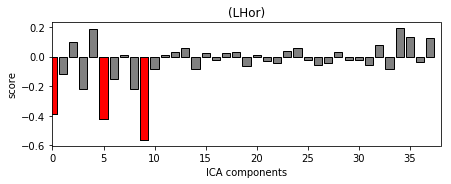

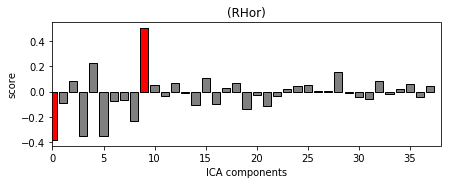

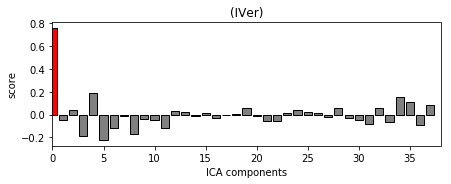

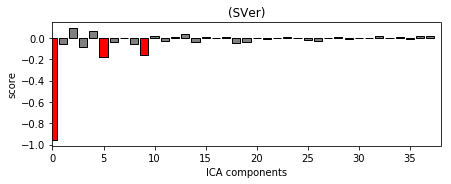

In [14]:
# Find components to drop, based on correlation with EOG channels
drop_inds = []
for chi in eog_chs:
    inds, scores = ica.find_bads_eog(eeg_dat, ch_name=chi, threshold=2.5,
                                     l_freq=1, h_freq=10, verbose=False)
    drop_inds.extend(inds)
    ica.plot_scores(scores, exclude=inds, labels=chi);
    
drop_inds = list(set(drop_inds))

In [15]:
# Check the set of components to be dropped
ica.exclude = drop_inds

print('Number of component to drop: \t', len(ica.exclude))
print('Dropped component indices: \t', ica.exclude)

Number of component to drop: 	 3
Dropped component indices: 	 [0, 9, 5]


In [16]:
# Save out the ICA solution
#ica.save('test-ica.fif')

# Note: can later load ICAs:
# from mne.preprocessing import read_ica
# ica = read_ica(ica_file)

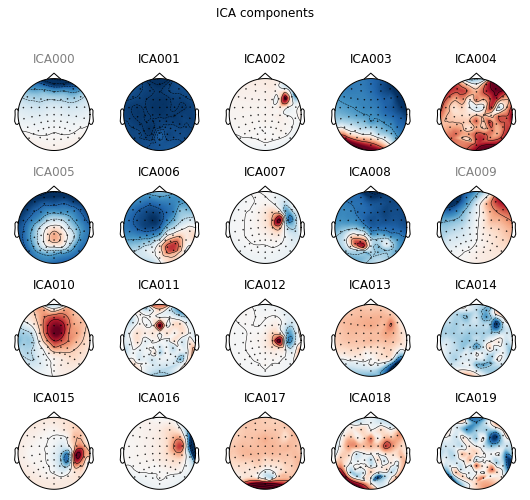

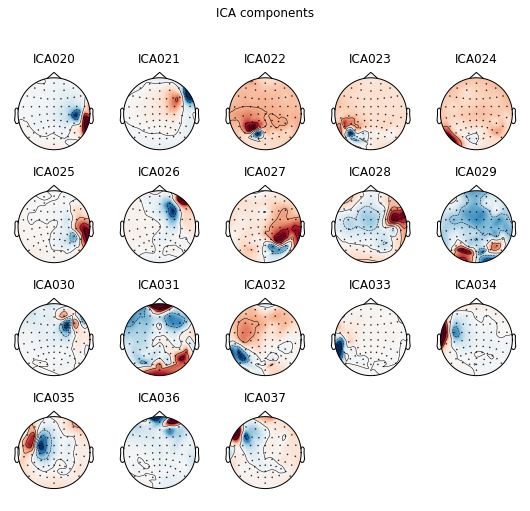

In [17]:
# Visualize the ICA components
ica.plot_components();

    Using multitaper spectrum estimation with 7 DPSS windows


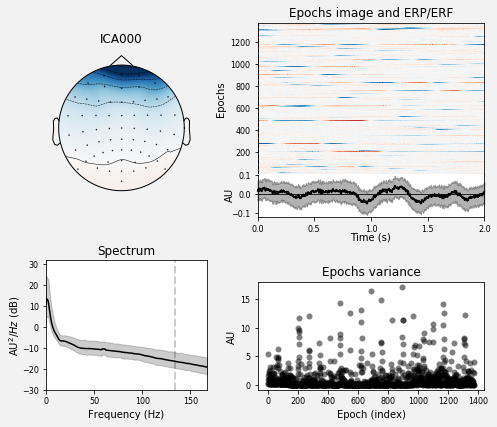

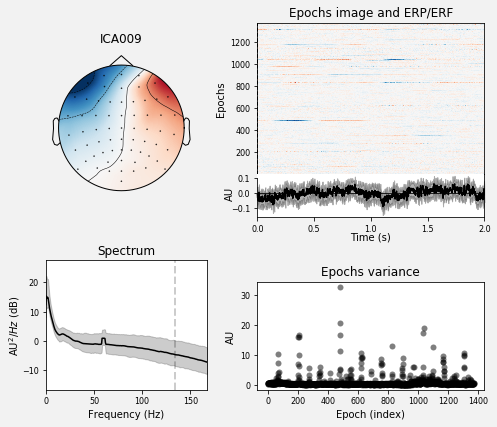

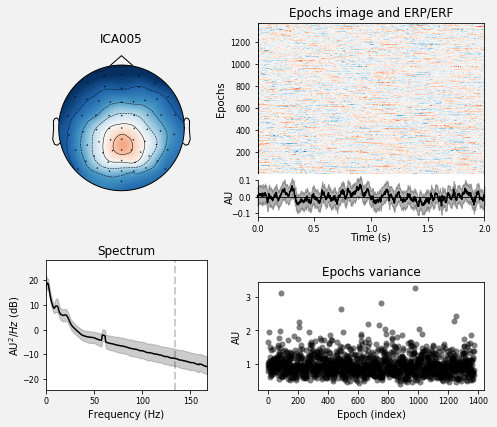

In [18]:
# Check description of the components that are marked to be dropped
ica.plot_properties(eeg_dat, picks=drop_inds);

Transforming to ICA space (38 components)
Zeroing out 3 ICA components


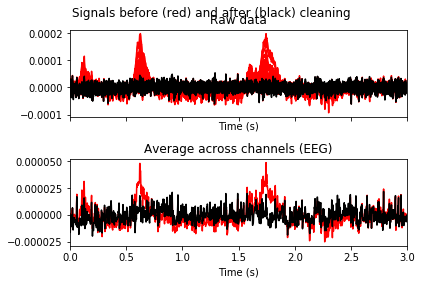

In [19]:
# Check the overlay of the data, with the components to be rejected
ica.plot_overlay(eeg_dat, exclude=drop_inds);

In [20]:
# Apply ICA to data
eeg_dat = ica.apply(eeg_dat);

Transforming to ICA space (38 components)
Zeroing out 3 ICA components


## Event management

In [21]:
# Get event information
evs = mne.find_events(eeg_dat, shortest_event=1, verbose=False)

# Check all used event codes
ev_codes = np.unique(evs[:, 2])

In [22]:
# Set up event code dictionary, with key labels for each event type
ev_dict = {'LeLo1': [201, 202], 'LeLo2': [205, 206], 'LeLo3': [209, 210], 
           'RiLo1': [203, 204], 'RiLo2': [207, 208], 'RiLo3': [211, 212]}

# Event codes for correct and incorrect codes
corr_codes = [2, 1]
inco_codes = [102, 101]

In [23]:
# Extract a list of all the event labels
all_trials = [it for it2 in ev_dict.values() for it in it2]

# Create list of new event codes to be used to label correct trials (300s)
all_trials_new = [it + 100 for it in all_trials]
# This is an annoying way to collapse across the doubled event markers from above
all_trials_new = [it - 1 if not ind%2 == 0 else it for ind, it in enumerate(all_trials_new)]
# Get labelled dictionary of new event names
ev_dict2 = {k:v for k, v in zip(ev_dict.keys(), set(all_trials_new))}

In [24]:
# Initialize variables to store new event definitions
evs2 = np.empty(shape=[0, 3], dtype='int64')
lags = np.array([])

# Loop through, creating new events for all correct trials
t_min, t_max = -0.4, 3.0
for ref_id, targ_id, new_id in zip(all_trials, corr_codes * 6, all_trials_new):
    
    t_evs, t_lags = mne.event.define_target_events(evs, ref_id, targ_id, srate, t_min, t_max, new_id)
    
    if len(t_evs) > 0:
        evs2 = np.vstack([evs2, t_evs])
        lags = np.concatenate([lags, t_lags])

In [25]:
# Check how many of each event type there are
print(Counter(evs[:, 2]))
print('\n')
print(Counter(evs2[:, 2]))

Counter({55: 800, 1: 395, 2: 392, 214: 50, 213: 50, 208: 50, 215: 50, 202: 50, 211: 50, 206: 50, 204: 50, 201: 50, 203: 50, 216: 50, 205: 50, 212: 50, 209: 50, 207: 50, 210: 50, 65536: 9, 101: 8, 102: 4})


Counter({305: 100, 309: 100, 307: 100, 301: 99, 303: 99, 311: 98})


### FOOOF 

In [26]:
# Set channel of interest
ch_ind = eeg_dat.ch_names.index('Oz')

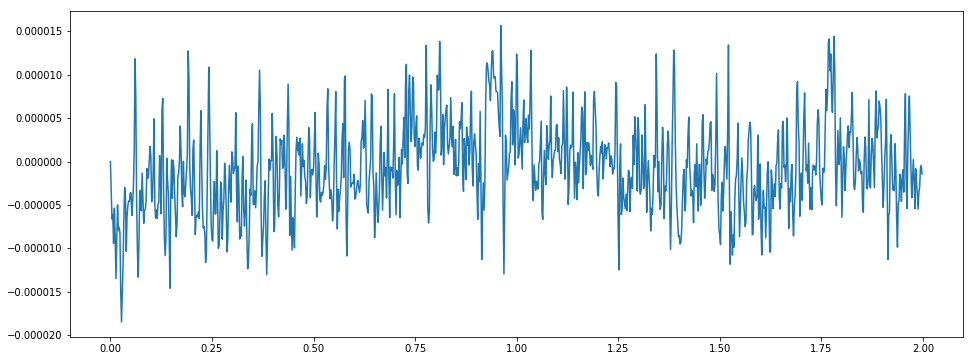

In [27]:
# Plot a segment of data - to eyeball
start = 0 # Index to start plotting at, in samples
inds = [start, start + 2*srate]  # 2 seconds of data
fig = plt.figure(figsize=[16, 6])
plt.plot(eeg_dat.times[inds[0]:inds[1]], eeg_dat._data[ch_ind, inds[0]:inds[1]])

In [28]:
# PSD settings
n_fft, n_overlap, n_per_seg = int(2*srate), int(srate), int(2*srate)

# Data settings
fmin, fmax = 1, 50
tmin, tmax = 5, 125
#tmin, tmax = 10, 130
#tmin, tmax = 100, 220
#tmin, tmax = 1500, 1620

# Calculate PSDs (across all channels) - from the first 2 minute of data
psds, freqs = mne.time_frequency.psd_welch(eeg_dat, fmin=fmin, fmax=fmax, tmin=tmin ,tmax=tmax,
                                           n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg, verbose=False)

In [29]:
# Initialize FOOOFGroup object
f_range = [3, 25]
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_amplitude=0.05, peak_threshold=1.5)

# Run FOOOF across all power spectra
fg.fit(freqs, psds, f_range, n_jobs=-1)

Running FOOOFGroup across 64 power spectra.


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 25 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.9570, 0.6165                                         
                                                                                                  
                                       3 peaks were found:                                        
          

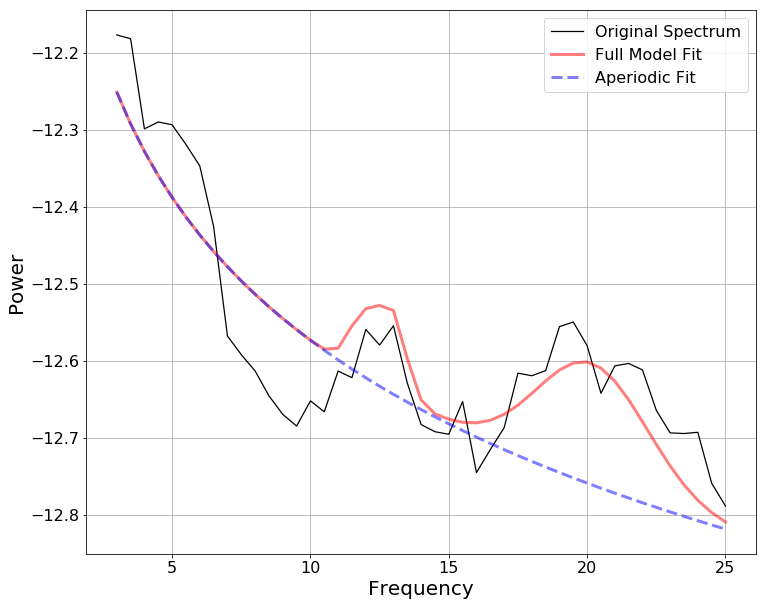

In [30]:
# Check FOOOF model fit of particular channel of interest
fm = fg.get_fooof(ch_ind, True)
fm.print_results()
fm.plot()

In [31]:
# Extract individualized CF from channel Oz
fooof_freq, _, fooof_bw = get_band_peak(fm.peak_params_, [7, 14])

# If not FOOOF alpha extracted, reset to 10
if np.isnan(fooof_freq):
    fooof_freq = 10
    
print('Alpha CF: \t{:0.4f}'.format(fooof_freq))
print('Alpha BW: \t{:0.4f}'.format(fooof_bw))

Alpha CF: 	12.9438
Alpha BW: 	1.0000


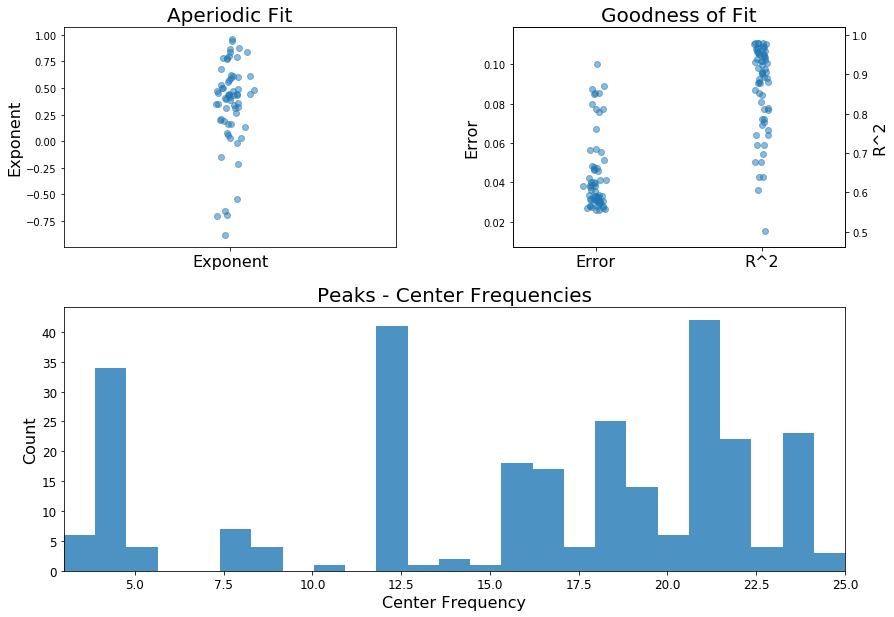

In [32]:
# Check a summary of the FOOOFGroup results across all channels
fg.plot()

In [33]:
# Extract some FOOOF data across all electrodes

# Extract slopes - all channels
all_sls = fg.get_all_data('aperiodic_params', 'exponent')

# Extract alpha oscillations - all channels
alphas = get_band_peak_group(fg.get_all_data('peak_params'), [7, 14], len(fg))

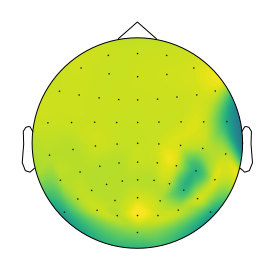

In [34]:
# Plot alpha topography
dat_ind = 0 # 0:CF; 1:Amp; 2:BW

# For sake of visualization, replace any NaN with the mean
temp_dat = alphas[:, dat_ind]
inds = np.where(np.isnan(temp_dat))
temp_dat[inds] = np.nanmean(temp_dat)

mne.viz.plot_topomap(temp_dat, eeg_dat.info, cmap=cm.viridis, contours=0);

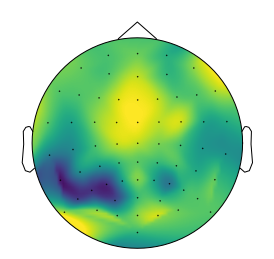

In [35]:
# Plot slope topography
mne.viz.plot_topomap(all_sls, eeg_dat.info, cmap=cm.viridis, contours=0);

## Filtering & Envelope

#### Canonical Alpha Range

In [36]:
# Filter data to canonical alpha band: 8-12 Hz
alpha_dat = eeg_dat.copy()
alpha_dat.filter(8, 12, fir_design='firwin')

Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 845 samples (1.650 sec) selected


<RawEDF  |  YA_042007-1_RAW.bdf, n_channels x n_times : 73 x 1406464 (2747.0 sec), ~783.5 MB, data loaded>

#### FOOOF defined subject-specific alpha band

In [37]:
# Filter data to FOOOF derived alpha band
fooof_dat = eeg_dat.copy()
fooof_dat.filter(fooof_freq-2, fooof_freq+2, fir_design='firwin')

#filt_bw = fooof_bw * 1.5
#fooof_dat.filter(fooof_freq-filt_bw, fooof_freq+filt_bw, fir_design='firwin')

Setting up band-pass filter from 11 - 15 Hz
l_trans_bandwidth chosen to be 2.7 Hz
h_trans_bandwidth chosen to be 3.7 Hz
Filter length of 619 samples (1.209 sec) selected


<RawEDF  |  YA_042007-1_RAW.bdf, n_channels x n_times : 73 x 1406464 (2747.0 sec), ~783.5 MB, data loaded>

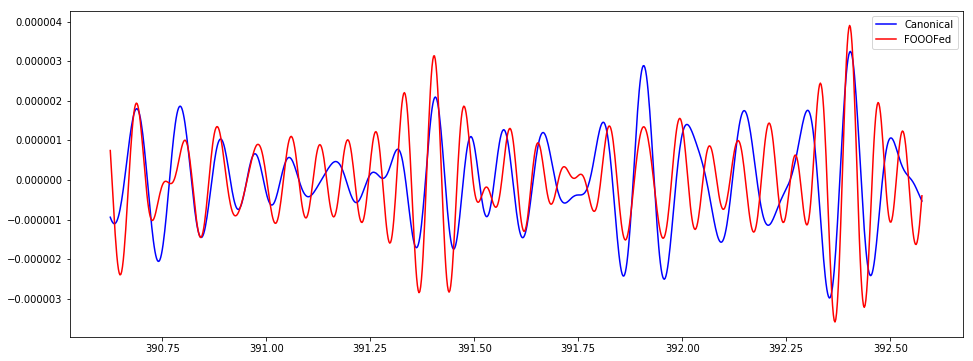

In [38]:
# Plot the differently filtered traces - check for differences
inds = [200000, 201000] # Arbitrary time points
fig = plt.figure(figsize=[16, 6])
plt.plot(alpha_dat.times[inds[0]:inds[1]], alpha_dat._data[ch_ind, inds[0]:inds[1]], 'b', label='Canonical')
plt.plot(fooof_dat.times[inds[0]:inds[1]], fooof_dat._data[ch_ind, inds[0]:inds[1]], 'r', label='FOOOFed')
plt.legend()

In [39]:
# Take the analytic amplitude (hilbert) of the alpha-filtered signals
alpha_dat.apply_hilbert(envelope=True)
fooof_dat.apply_hilbert(envelope=True)

/anaconda3/envs/eeg/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


<RawEDF  |  YA_042007-1_RAW.bdf, n_channels x n_times : 73 x 1406464 (2747.0 sec), ~783.5 MB, data loaded>

### Epoching

In [40]:
# Epoch settings
#tmin, tmax = -0.5, 1.2
tmin, tmax = -0.85, 1.1

# Epoch trials - raw data for trial rejection
#epochs = mne.Epochs(eeg_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.5, -0.35), preload=True)
epochs = mne.Epochs(eeg_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=None, preload=True)

# Epoch trials - filtered version
epochs_alpha = mne.Epochs(alpha_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.50, -0.35), preload=True);
epochs_fooof = mne.Epochs(fooof_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.50, -0.35), preload=True);

596 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 596 events and 999 original time points ...


<ipython-input-40-fdb9bd46659d>:7: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(eeg_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=None, preload=True)


0 bad epochs dropped
596 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 596 events and 999 original time points ...


<ipython-input-40-fdb9bd46659d>:10: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs_alpha = mne.Epochs(alpha_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.50, -0.35), preload=True);


0 bad epochs dropped
596 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 596 events and 999 original time points ...


<ipython-input-40-fdb9bd46659d>:11: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs_fooof = mne.Epochs(fooof_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.50, -0.35), preload=True);


0 bad epochs dropped


### Pre-Processing: Autoreject

In [41]:
if run_auto_reject:
    
    # Initialize autoreject object
    ar = AutoReject(n_jobs=4, verbose=False)
    
    # Fit the autoreject solution
    ar.fit(epochs)

else:
    ar = read_auto_reject(os.path.join(res_path, 'AR', subj_label + '-ar.hdf5'))
    ar.verbose = 'tqdm_notebook'

Computing thresholds ...


In [42]:
# Save out the autoreject solution
#ar.save('test-ar.hdf5', overwrite=True)

# Note: can later load ARs
# from autoreject import read_auto_reject
# ar = read_auto_reject(ar_file)

In [43]:
# Apply autoreject to the original epochs object it was learnt on
epochs, rej_log = ar.transform(epochs, return_log=True)

Dropped 18 epochs


In [44]:
# Apply autoreject to the copies of the data - apply interpolation, then drop same epochs
_apply_interp(rej_log, epochs_alpha, ar.threshes_, ar.picks_, ar.verbose)
epochs_alpha.drop(rej_log.bad_epochs)
_apply_interp(rej_log, epochs_fooof, ar.threshes_, ar.picks_, ar.verbose)
epochs_fooof.drop(rej_log.bad_epochs)

Dropped 18 epochs
Dropped 18 epochs


<Epochs  |   578 events (all good), -0.849609 - 1.09961 sec, baseline [-0.5, -0.35], ~321.8 MB, data loaded,
 'LeLo1': 98
 'LeLo2': 96
 'LeLo3': 95
 'RiLo1': 99
 'RiLo2': 97
 'RiLo3': 93>

In [45]:
# Check which epochs were dropped
drop_inds = np.where(rej_log.bad_epochs)[0]
print(drop_inds)

[ 15 103 105 132 167 188 239 288 298 303 352 383 456 501 562 563 584 585]


### Set channel clusters

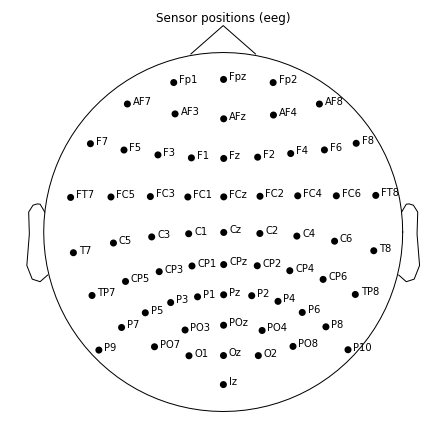

In [46]:
# Replot channel positions
eeg_dat.plot_sensors(show_names=True);

In [47]:
# Set channel clusters for analysis - take channels contralateral to stimulus presentation
le_chs = ['P3', 'P5', 'P7', 'P9', 'O1', 'PO3', 'PO7']
le_inds = [epochs.ch_names.index(chn) for chn in le_chs]
ri_chs = ['P4', 'P6', 'P8', 'P10', 'O2', 'PO4', 'PO8']
ri_inds = [epochs.ch_names.index(chn) for chn in ri_chs]

### Trial-Related Analysis

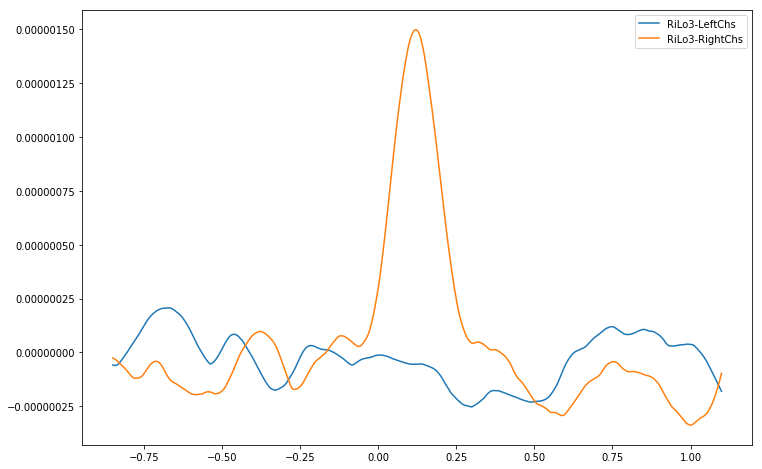

In [48]:
# Check lateralized alpha response for particular trial type
trial_type = 'RiLo3'
times = np.arange(tmin, tmax, 1/srate)
plt.figure(figsize=[12, 8])
plt.plot(times, np.mean(epochs_alpha[trial_type]._data[:, le_inds, :], 0).T[:, 0], label=trial_type+'-LeftChs')
plt.plot(times, np.mean(epochs_alpha[trial_type]._data[:, ri_inds, :], 0).T[:, 0], label=trial_type+'-RightChs')
plt.legend();

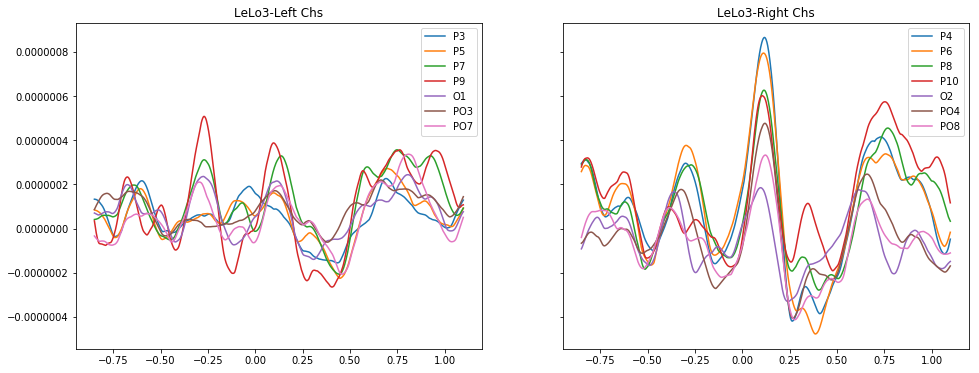

In [49]:
# Plot the responses across channels
trial_type = 'LeLo3'
times = np.arange(tmin, tmax, 1/srate)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[16, 6])

ax1.plot(times, np.mean(epochs_alpha[trial_type]._data[:, le_inds, :], 0).T);
ax1.set_title(trial_type+'-Left Chs')
ax1.legend(le_chs);

ax2.plot(times, np.mean(epochs_alpha[trial_type]._data[:, ri_inds, :], 0).T);
ax2.set_title(trial_type+'-Right Chs')
ax2.legend(ri_chs);

In [50]:
# Pull out channel of interest for each load level - canonical data
#  Channels extracted are those contralateral to stimulus presentation
lo1_a = np.concatenate([epochs_alpha['LeLo1']._data[:, ri_inds, :], epochs_alpha['RiLo1']._data[:, le_inds, :]], 0)
lo2_a = np.concatenate([epochs_alpha['LeLo2']._data[:, ri_inds, :], epochs_alpha['RiLo2']._data[:, le_inds, :]], 0)
lo3_a = np.concatenate([epochs_alpha['LeLo3']._data[:, ri_inds, :], epochs_alpha['RiLo3']._data[:, le_inds, :]], 0)

In [51]:
# Pull out channel of interest for each load level - fooofed data
#  Channels extracted are those contralateral to stimulus presentation
lo1_f = np.concatenate([epochs_fooof['LeLo1']._data[:, ri_inds, :], epochs_fooof['RiLo1']._data[:, le_inds, :]], 0)
lo2_f = np.concatenate([epochs_fooof['LeLo2']._data[:, ri_inds, :], epochs_fooof['RiLo2']._data[:, le_inds, :]], 0)
lo3_f = np.concatenate([epochs_fooof['LeLo3']._data[:, ri_inds, :], epochs_fooof['RiLo3']._data[:, le_inds, :]], 0)

In [52]:
# Calculate average across trials and channels
lo1_a_avg = np.mean(lo1_a, 1).mean(0)
lo2_a_avg = np.mean(lo2_a, 1).mean(0)
lo3_a_avg = np.mean(lo3_a, 1).mean(0)
canonical_avg = np.vstack([lo1_a_avg, lo2_a_avg, lo3_a_avg])

# Calculate average across trials and channels
lo1_f_avg = np.mean(lo1_f, 1).mean(0)
lo2_f_avg = np.mean(lo2_f, 1).mean(0)
lo3_f_avg = np.mean(lo3_f, 1).mean(0)
fooofed_avg = np.vstack([lo1_f_avg, lo2_f_avg, lo3_f_avg])

In [53]:
# Plot alpha response between different alpha filters
#plot_alpha_response_compare(canonical_avg, fooofed_avg, [tmin, tmax], srate)

## FOOOFING TRIAL AVERAGED DATA

In [54]:
# Set labels
load_labels = ['Load1', 'Load2', 'Load3']
side_labels = ['Contra', 'Ipsi']
seg_labels = ['Pre', 'Early', 'Late']

# Set up the dictionary to store all the FOOOF results
fm_dict = dict()
for load_label in load_labels:
    fm_dict[load_label] = dict()
    for side_label in side_labels:
        fm_dict[load_label][side_label] = dict()
        for seg_label in seg_labels:
            fm_dict[load_label][side_label][seg_label] = []

In [55]:
# Eyeball fm_dict works
fm_dict

{'Load1': {'Contra': {'Pre': [], 'Early': [], 'Late': []},
  'Ipsi': {'Pre': [], 'Early': [], 'Late': []}},
 'Load2': {'Contra': {'Pre': [], 'Early': [], 'Late': []},
  'Ipsi': {'Pre': [], 'Early': [], 'Late': []}},
 'Load3': {'Contra': {'Pre': [], 'Early': [], 'Late': []},
  'Ipsi': {'Pre': [], 'Early': [], 'Late': []}}}

In [56]:
# Settings for trial averaged FOOOFing
fmin, fmax = 3, 25
#n_fft, n_overlap, n_per_seg = 4*srate, srate/2, srate*2
n_fft, n_overlap, n_per_seg = 4*srate, srate/4, srate

seg_times = [(-0.85, -0.35), (0.1, 0.6), (0.5, 1.0)]
#tmin, tmax = -0.1, 1.1

In [57]:
# Initialize FOOOF object
fm = FOOOF(peak_width_limits=[1, 6], min_peak_amplitude=0.05, peak_threshold=1.5)

In [58]:
# Loop through loads

#avg_func = np.mean
avg_func = np.median

for seg_label, seg_time in zip(seg_labels, seg_times):
    tmin, tmax = seg_time[0], seg_time[1]

    for le_label, ri_label, load_label in zip(['LeLo1', 'LeLo2', 'LeLo3'],
                                              ['RiLo1', 'RiLo2', 'RiLo3'], 
                                              load_labels):

        trial_freqs, le_trial_psds = periodogram(
            epochs[le_label]._data[:, :, _time_mask(epochs.times, tmin, tmax, srate)],
            srate, window='hann', nfft=4*srate)
        
        le_avg_psd_contra = avg_func(avg_func(le_trial_psds[:, ri_inds, :], 0), 0)
        le_avg_psd_ipsi = avg_func(avg_func(le_trial_psds[:, le_inds, :], 0), 0)

        trial_freqs, ri_trial_psds = periodogram(
            epochs[ri_label]._data[:, :, _time_mask(epochs.times, tmin, tmax, srate)],
            srate, window='hann', nfft=4*srate)
        
        ri_avg_psd_contra = avg_func(avg_func(ri_trial_psds[:, le_inds, :], 0), 0)
        ri_avg_psd_ipsi = avg_func(avg_func(ri_trial_psds[:, ri_inds, :], 0), 0)

        avg_psd_contra = avg_func(np.vstack([le_avg_psd_contra, ri_avg_psd_contra]), 0)
        avg_psd_ipsi = avg_func(np.vstack([le_avg_psd_ipsi, ri_avg_psd_ipsi]), 0)

        # Fit FOOOF, and collect results
        fm.fit(trial_freqs, avg_psd_contra, [fmin, fmax])
        fm_dict[load_label]['Contra'][seg_label] = fm.copy()
        
        fm.fit(trial_freqs, avg_psd_ipsi, [fmin, fmax])
        fm_dict[load_label]['Ipsi'][seg_label] = fm.copy()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 25 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.8893, 0.8083                                         
                                                                                                  
                                       6 peaks were found:                                        
          

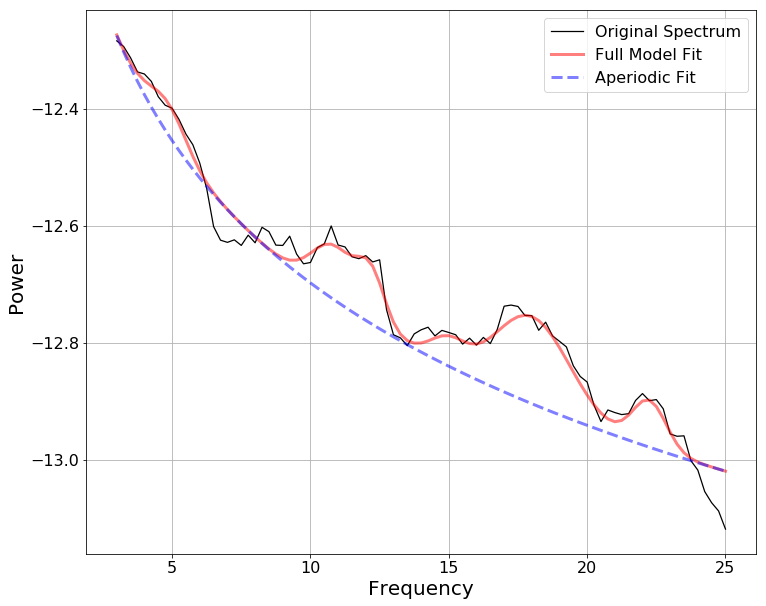

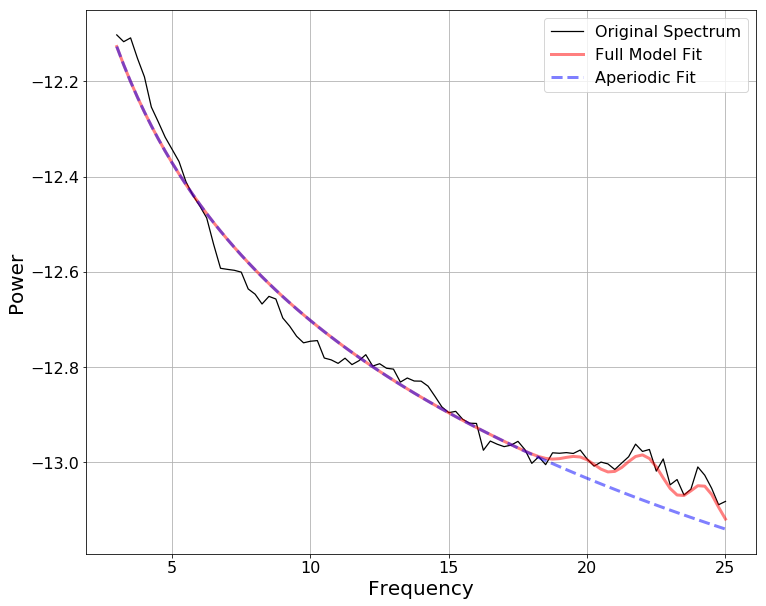

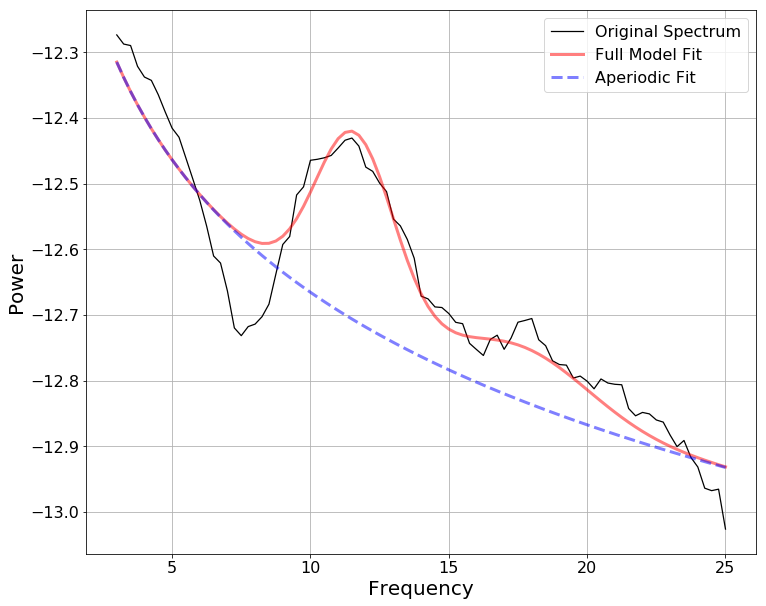

In [59]:
# Print & plot trial average results
cur_load = 'Load3'
for fm in fm_dict[cur_load]['Contra'].values():
    fm.print_results()
    fm.plot()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 25 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.9444, 0.7995                                         
                                                                                                  
                                       5 peaks were found:                                        
          

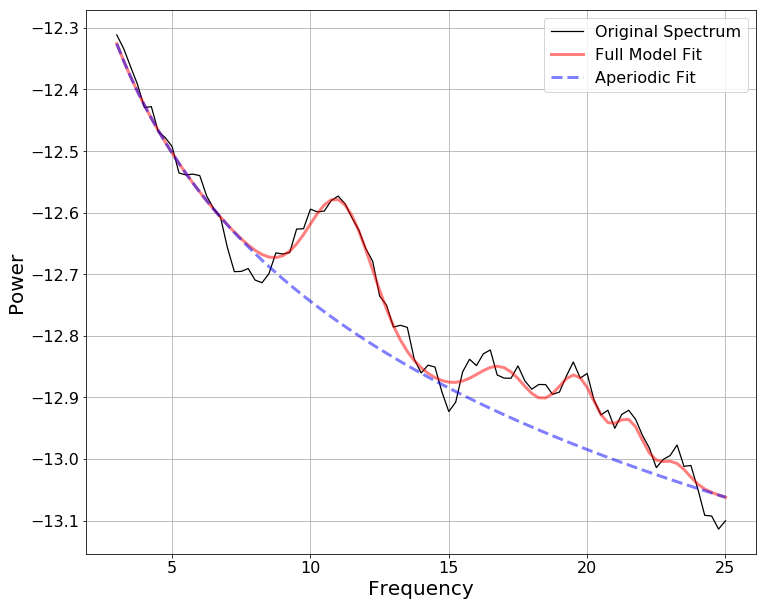

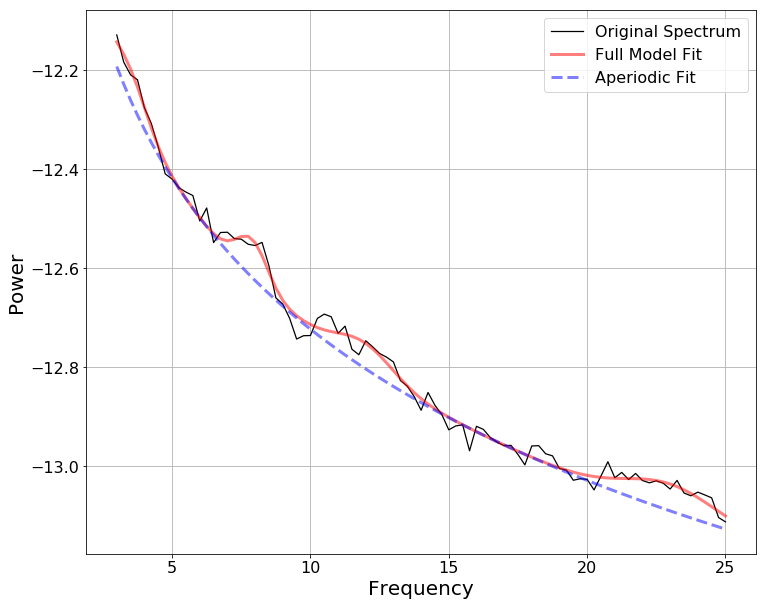

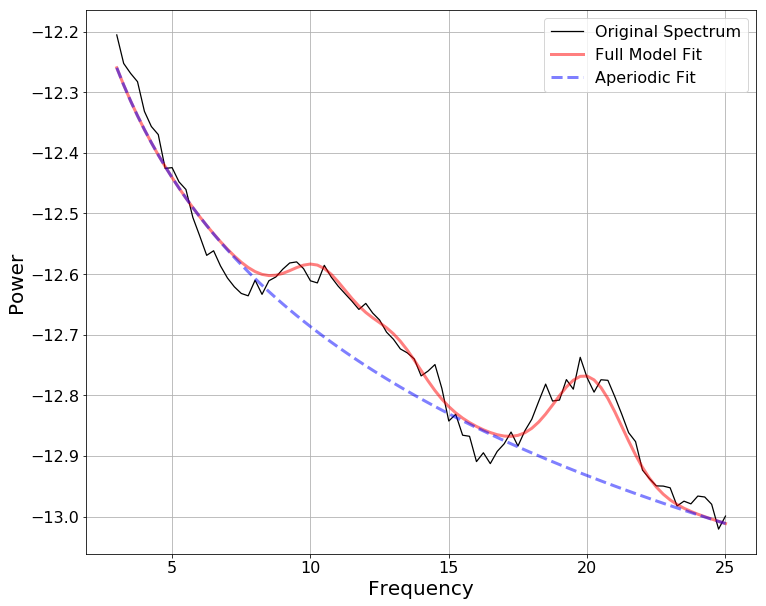

In [60]:
# Print & plot trial average results
cur_load = 'Load3'
for fm in fm_dict[cur_load]['Ipsi'].values():
    fm.print_results()
    fm.plot()